# Softmax

Vectorized softmax classifier model with cross-entropy loss. Includes support for:

- Minibatching
- Optional gradient checking
- L2 Regularization
- Logging so you can see what the scores, probabilities, gradients, etc. were after every minibatch

In [8]:
from collections import namedtuple

Model = namedtuple('Model', ['X', 'ys', 'W', 'b', 'scores', 'probs', 'dscores', 'db', 'dW', 'loss'])
State = namedtuple('State', ['loss', 'dws', 'dbs'])

In [9]:
from lib.softmax import softmax_vectorized

class Softmax:
    """Initialize model parameters
    
    Additionally calculate batch index so we can use minibatches with each training iteration
    
    If you want to inspect the scores after each training example, the pass inspect. If you do
    this then you better set a batch_size to 1. Otherwise you'll only ever get the scores of
    the last training example in the minibatch
    
    """
    def __init__(self, X, ys_train, num_classes, W=None, b=None,
                 learning_rate=0.001, regularizer=1., batch_size=None,
                gradient_checking=False, inspect=False):
        """Initializes softmax classifier
        
        Parameters
        ----------
        xs_train : 2d array of training example inputs
        ys_train : list of labels
        num_classes : number of target classes
        ws : list (length 2) of weights
        bs : list (length 2) of biases
        learning_rate : learning rate constant
        regularizer : regularization constant
        batch_size : size of minibatch
        gradient_checking : boolean whether to perform gradient checking during training
        inspect : boolean whether to log all data after every learning session from a training example
        
        """
        (self.N, self.M) = X.shape
        
        self.X_train, self.ys_train = X, ys_train
        self.W = np.random.randn(num_classes, self.N)
        self.b = np.random.randn(num_classes).reshape(num_classes, 1)
        
        self.learning_rate = learning_rate
        self.regularizer = regularizer
        
        self.batch_size = self.m if not batch_size else batch_size
        self.batch_index = 0
        
        self.gradient_checking = gradient_checking
        self.inspect = inspect
        
        # Info from the *last* minibatch that was used to learn from
        self.X, self.ys = None, None
        self.scores, self.dscores = None, None
        self.probs = None
        self.dW, self.dbs = None, None
        self.loss = None
        
    def forward_backward_prop(self, W=None, b=None):
        """Perform forward and backward prop over a minibatch of training examples
        
        Returns loss and gradients
        
        """
        W = self.W if not type(W) == np.ndarray else W
        b = self.b if not type(b) == np.ndarray else b
        
        # Get minibatch of training examples
        low, high = self.batch_index*self.batch_size, (self.batch_index+1)*self.batch_size
        X = self.X_train[:, low:high].reshape(self.N, self.batch_size)
        ys = self.ys_train[low:high]
        
        # Forward Pass (predictions)
        scores = W @ X + b
        probs = softmax_vectorized(scores)
        y_hats = probs[ys, range(self.batch_size)]

        # Loss
        losses = -np.log(y_hats)
        loss = sum(losses)
        loss += (self.regularizer * (0.5*(W**2).sum() + 0.5*(b**2).sum()))

        # Backpropagate to find dw and db
        dscores = probs
        dscores[ys, range(self.batch_size)] -= 1
        
        db = dscores.sum(axis=1, keepdims=True)
        dW = dscores @ X.T
        
        # Regularization
        db += (self.regularizer*b)
        dW += (self.regularizer*W)
        
        # Log additional info?
        if self.inspect:
            self.X, self.ys = X, ys
            self.scores, self.dscores = scores, dscores
            self.dscores[ys, range(self.batch_size)] += 1
            self.probs = probs
        
        return State(loss/self.M, dW/self.M, db/self.M)
    
    def learn(self):
        """Learn from a minibatch of training examples
        
        Have the model run forward-backward prop on these examples and average the gradients
        
        """        
        loss, dW, db = self.forward_backward_prop()
        
        self.gradient_check(dW, db)
        
        self.W = self.W - self.learning_rate*dW
        self.b = self.b - self.learning_rate*db
        
        # Update batch index so the next time the next batch in line is used
        self.batch_index = (self.batch_index+1) % (self.M//self.batch_size)
        
        # Log additional info?
        if self.inspect:
            self.dW = dW
            self.db = db
            self.loss = loss
    
    def gradient_check(self, analytic_dW, analytic_db):
        """Verify gradient correctness
        
        The analytic_dws and analytic_dbs come from doing forward-backward
        prop just a second ago. We numerically estimate these gradients on
        the *same* minibatch the analytic gradients were computed from and
        compare them to see if they are close.
        
        Note the same minibatch is being used because this function gets
        called *before* the update to batch_index
        
        """
        if not self.gradient_checking:
            return
        
        numerical_dW, numerical_db = self.numerical_gradients()

        # Compute relative error
        dW_error = abs(numerical_dW - analytic_dW) / (abs(numerical_dW) + abs(analytic_dW))
        db_error = abs(numerical_db - analytic_db) / (abs(numerical_db) + abs(analytic_db))

        try:
            assert(np.linalg.norm(dW_error) < 1e-6 and np.linalg.norm(db_error) < 1e-6)
        except AssertionError:
            warn('Gradient check failed!')
            warn('dW relative error: {}'.format(dW_error))
            warn('db relative error: {}'.format(db_error))
            
    def numerical_gradients(self):
        """Compute numerical gradients of f with respect to self.W and self.b

        Returns approximation for df/dW and df/db

        """
        dW, db = np.zeros_like(self.W), np.zeros_like(self.b)
        h = np.zeros_like(self.W)
        step = 1e-5
        W, b = self.W, self.b
    
        # df/dW
        it = np.nditer(W, flags=['multi_index'])
        while not it.finished:
            ix = it.multi_index
            h[ix] = step
            
            dW[ix] = (self.forward_backward_prop(W+h, b).loss - self.forward_backward_prop(W-h, b).loss) / (2*step)

            h[ix] = 0
            it.iternext()
            
        # df/db
        h = np.zeros_like(self.b)
        it = np.nditer(b, flags=['multi_index'])
        while not it.finished:
            ix = it.multi_index
            h[ix] = step
            
            db[ix] = (self.forward_backward_prop(W, b+h).loss - self.forward_backward_prop(W, b-h).loss) / (2*step)

            h[ix] = 0
            it.iternext()

        return dW, db

    @property
    def info(self):
        return Model(self.X, self.ys,
                     self.W, self.b,
                     self.scores, self.probs, self.dscores,
                     self.db, self.dW, self.loss)

## Run it!

In [10]:
from data.softmax import X_train, ys_train

sm = Softmax(X_train, ys_train, num_classes=2, learning_rate=.01, regularizer=0, batch_size=1, gradient_checking=False, inspect=True)

def states(iters):
    for _ in range(iters):
        sm.learn()
        yield sm.info
        
states = list(states(50000))

## Plot the Weights!

In [11]:
df = pd.DataFrame(states, columns=Model._fields)

Params = namedtuple('Params', ['x', 'y', 'label', 'w11', 'w21', 'w12', 'w22', 'b1', 'b2', 's1', 's2', 'p1', 'p2', 'ds1', 'ds2', 'db1', 'db2', 'dw11', 'dw21', 'dw12', 'dw22', 'loss'])

def params():
    for s in states:
        yield Params(s.X[0,0], s.X[1,0], s.ys[0],
                     s.W[0,0], s.W[1,0], s.W[0,1], s.W[1,1], s.b[0, 0], s.b[1, 0],
                     s.scores[0, 0], s.scores[1, 0], s.probs[0, 0], s.probs[1, 0], s.dscores[0, 0], s.dscores[1, 0],
                     s.db[0, 0], s.db[1, 0], s.dW[0,0], s.dW[1,0], s.dW[0,1], s.dW[1,1],
                     s.loss)

params = list(params())

x  y
1  1    Axes(0.125,0.125;0.775x0.775)
   2    Axes(0.125,0.125;0.775x0.775)
2  1    Axes(0.125,0.125;0.775x0.775)
   2    Axes(0.125,0.125;0.775x0.775)
Name: loss, dtype: object

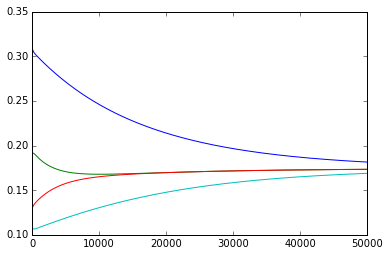

In [12]:
df = pd.DataFrame(params, columns=Params._fields)

df.groupby(['x', 'y'])['loss'].plot()

x  y
1  1    Axes(0.125,0.125;0.775x0.775)
   2    Axes(0.125,0.125;0.775x0.775)
2  1    Axes(0.125,0.125;0.775x0.775)
   2    Axes(0.125,0.125;0.775x0.775)
dtype: object

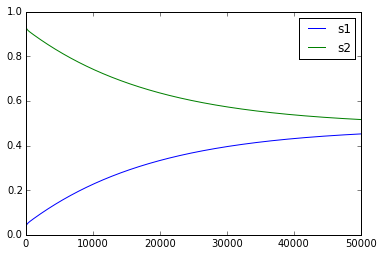

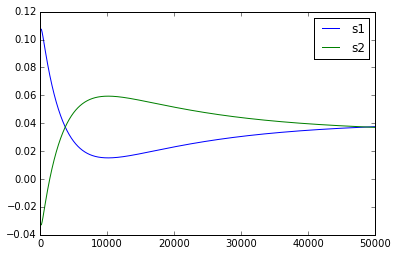

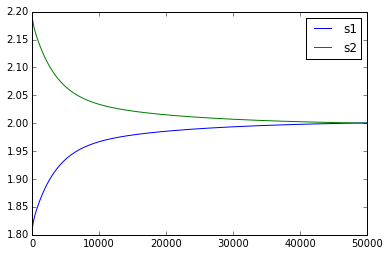

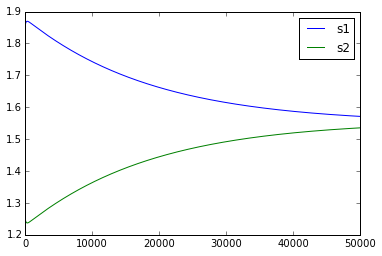

In [13]:
df.groupby(['x', 'y'])[['s1', 's2']].plot()

## XOR Fail

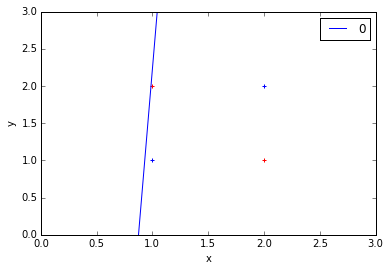

In [14]:
from ipywidgets import interact, fixed

@interact(X_train=fixed(X_train), ys_train=fixed(ys_train), view_index=(0, len(states)), states=fixed(states))
def plot(X_train, ys_train, view_index, states):
    s = states[view_index]
    X = X_train.T
    
    # Plot positives
    poss = X[:len(X)//2]
    xs, ys = poss[:, 0], poss[:, 1]
    axes = pd.DataFrame({'x': xs, 'y': ys}).plot(kind='scatter', x='x', y='y', color='b', marker='+')
    
    # Plot negatives
    negs = X[len(X)//2:]
    xs, ys = negs[:, 0], negs[:, 1]
    axes = pd.DataFrame({'x': xs, 'y': ys}).plot(ax=axes, kind='scatter', x='x', y='y', color='r', marker='+')
    
    # Generate decision boundary
    xs = np.linspace(0, 3)
    ys = (s.W[0,0]-s.W[1,0]*xs + (s.b[0]-s.b[1])) / (s.W[1,1]-s.W[0,1])
    
    # Plot decision boundary
    axes = pd.DataFrame(ys, index=xs).plot(ax=axes)
    
    axes.set_ylim(0, 3)
    axes.set_xlim(0, 3)